In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pickle import dump, load
from ipywidgets import widgets, interactive_output
from IPython.display import display

h = 8; c=5*h; f = 2*15*h

# Functions

In [3]:
def show_age_sl_results(T, G, S, alpha, d, y, z, show=True):
    fig, axes = plt.subplots(nrows=len(G), ncols=len(T)+3, figsize=(22, 4))
    fig.subplots_adjust(wspace=0, hspace=0)

    sl = dict(); total_sl = dict(); cm = plt.get_cmap("RdYlGn")
    for g in G:
        for t in T:
            sl[t,g] = [sum(z[s][t,k] for k in range(g+1))/d[s][t] for s in S]
            axes[g][t+2].hist(sl[t,g], bins=[i/10  for i in range(10)]+[1.01], color=cm(sum(sl[t,g])/len(S)), alpha=1)
            axes[g][t+2].set_xlim(-0.2, 1.2); axes[g][t+2].set_ylim(-5,len(S)+5)
            axes[g][t+2].set_yticks([]); axes[g][t+2].set_xticks([0,0.25,0.5,0.75,1]); axes[g][t+2].set_xticklabels([])
            axes[g][t+2].text(x=0.5, y=len(S)/2+2.5, s=f"{sum(sl[t,g])/len(S):.0%}", va="center", ha="center", fontsize=12)
        
        axes[g][0].spines[["bottom","top","left","right"]].set_visible(False); axes[g][2].spines[["bottom","top","left","right"]].set_visible(False)
        axes[g][0].set_xlim(0,2); axes[g][2].set_xlim(0,2)
        axes[g][0].set_ylim(0,2); axes[g][0].set_xticks([]); axes[g][0].set_yticks([])
        axes[g][2].set_ylim(0,2); axes[g][2].set_xticks([]); axes[g][2].set_yticks([])
        axes[g][0].text(x=1, y=1, s=f"g = {g}\n"+fr"$\alpha_{g}$ = {alpha[g]:.0%}", va="center", ha="center", fontsize=11)

        total_ix = 1
        total_sl[g] = [sum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S]
        axes[g][total_ix].hist(total_sl[g], bins=[i/10 for i in range(11)], color = cm(sum(total_sl[g])/len(S)), alpha = 1)
        axes[g][total_ix].set_xlim(-0.2, 1.2); axes[g][total_ix].set_ylim(-5,len(S)+5)
        axes[g][total_ix].set_yticks([]); axes[g][total_ix].set_xticks([0,0.25,0.5,0.75,1]); axes[g][total_ix].set_xticklabels([])
        axes[g][total_ix].text(x=0.5, y=len(S)/2+2.5, s=f"{sum(total_sl[g])/len(S):.0%}", va="center", ha="center", fontsize=12)
        if round(sum(total_sl[g])/len(S),4) == alpha[g]:
            axes[g][total_ix].vlines(x = [-0.15, 1.15], ymin=-5, ymax=len(S)+5, linewidth=5, color="gold")
            axes[g][total_ix].hlines(y = [-2.5, len(S)+2.5], xmin=-0.2, xmax=1.2, linewidth=5, color="gold")
        axes[g][total_ix].vlines(x=1.2, ymin=-5, ymax=len(S)+5, color="black")
        
    for t in [0]+T:
        if t in T:
            if y[t]: col = "midnightblue"; weight = "bold"
            else: col = "black"; weight = "normal"
            axes[0][t+2].set_title(f"t = {t}", color=col, fontweight=weight)
            axes[-1][t+2].set_xticklabels(["0","","50","","100"], fontsize=8)
        else:
            axes[0][total_ix].set_title("Total"); axes[-1][total_ix].set_xticklabels(["0","","50","","100"], fontsize=8)

    fig.suptitle("Total age-dependent service level constraints analysis", fontsize=16, y = 1.05)

    if not show: plt.close()

    return sl, total_sl

def show_age_sl_comparison_by_alpha_0(G, S, alpha, total_sl, an1, a0):

    nrows = int(np.ceil((len(a0)+1)/3))
    fig, subp = plt.subplots(nrows=nrows, ncols=3, figsize=(15,4*nrows))
    fig.subplots_adjust(hspace = 0.2)

    ncharts = int(nrows*3)
    if ncharts > 3: axes = [subp[int(np.floor(ix/3)),ix%3] for ix in range(ncharts)]

    cm = plt.get_cmap("gist_ncar")
    for ix in range(len(a0)):

        axes[ix].text(x=2.5, y=a0[0], s=fr"$\alpha_0$ = {a0[ix]:.0%}", fontsize=14, va="center", ha="center")
        axes[ix].hlines(y=a0[ix], xmin=-0.5, xmax=G[-1]+0.5, color="gainsboro", linestyle="--")
        for a in an1:
            
            if a >= a0[ix]:

                axes[ix].plot(G, [sum(total_sl[a0[ix], a][g])/len(S) for g in G], marker="D", linestyle="-", color=cm(a))
                for g in G:
                    if round(sum(total_sl[a0[ix], a][g])/len(S), 4) == alpha[a0[ix], a][g]:
                        axes[ix].plot(g, alpha[a0[ix], a][g], markerfacecolor="None", markeredgecolor="black", marker="D")


    for ax in axes[:len(a0)]:
        ax.set_xlim(-0.5, G[-1]+0.5)
        ax.set_ylim(a0[0]-0.1, 1.1)
        ax.set_xticks(G); ax.set_xlabel("Product ages")
        ticks = [a0[0]+i/10 for i in range(int(round(10*(1-a0[0]+0.1))))]
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{i:.0%}" for i in ticks])
        ax.spines[["top","right"]].set_visible(False)

    axes[ncharts-1].set_xticks([])
    axes[ncharts-1].set_yticks([])
    axes[ncharts-1].set_xlim(0.5, 6)
    ix = 1
    for a in an1:
        axes[ncharts-1].hlines(y=[ix], xmin=1, xmax=2, color=cm(a))
        axes[ncharts-1].text(x=2.5, y=ix, s=fr"$\alpha_{G[-1]}$ = {a:.0%}", ha="left", va="center")
        ix += 1
    axes[ncharts-1].plot(1.5, ix+1, marker="D", markeredgecolor="black", markerfacecolor="None")
    axes[ncharts-1].text(x=2.5, y=ix+1, s="Active constraint", ha="left", va="center")
    axes[ncharts-1].set_ylim(-1, ix+3)

    if len(a0)+1 < ncharts:
        for m in range(len(a0), ncharts-1):
            axes[m].spines[["bottom","top","left","right"]].set_visible(False)
            axes[m].set_xticks([]); axes[m].set_yticks([])

    fig.suptitle("Total age-dependent service level analysis, by fresh produce target service level", y=0.925, fontsize=16)

def show_age_sl_comparison_by_alpha_n1(G, S, alpha, total_sl, an1, a0):

    nrows = int(np.ceil((len(an1)+1)/3))
    fig, subp = plt.subplots(nrows=nrows, ncols=3, figsize=(15,nrows*4))
    fig.subplots_adjust(hspace = 0.2)

    ncharts = int(nrows*3)
    if ncharts > 3: axes = [subp[int(np.floor(ix/3)),ix%3] for ix in range(ncharts)]

    cm = plt.get_cmap("gist_ncar")
    for ix in range(len(an1)):

        axes[ix].text(x=2.5, y=a0[0], s=fr"$\alpha_{G[-1]}$ = {an1[ix]:.0%}", fontsize=14, va="center", ha="center")
        axes[ix].hlines(y=an1[ix], xmin=-0.5, xmax=G[-1]+0.5, color="gainsboro", linestyle="--")
        for a in a0:
            
            if a <= an1[ix]:

                axes[ix].plot(G, [sum(total_sl[a, an1[ix]][g])/len(S) for g in G], marker="D", linestyle="-", color=cm(a))
                for g in G:
                    if round(sum(total_sl[a, an1[ix]][g])/len(S), 4) == alpha[a, an1[ix]][g]:
                        axes[ix].plot(g, alpha[a, an1[ix]][g], markerfacecolor="None", markeredgecolor="black", marker="D")


    for ax in axes[:len(an1)]:
        ax.set_xlim(-0.5, G[-1]+0.5)
        ax.set_ylim(a0[0]-0.1, 1.1)
        ax.set_xticks(G); ax.set_xlabel("Product ages")
        ticks = [a0[0]+i/10 for i in range(int(round(10*(1-a0[0]+0.1))))]
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{i:.0%}" for i in ticks])
        ax.spines[["top","right"]].set_visible(False)

    axes[ncharts-1].set_xticks([])
    axes[ncharts-1].set_yticks([])
    axes[ncharts-1].set_xlim(0.5, 6)
    ix = 1
    for a in a0:
        axes[ncharts-1].hlines(y=[ix], xmin=1, xmax=2, color=cm(a))
        axes[ncharts-1].text(x=2.5, y=ix, s=fr"$\alpha_0$ = {a:.0%}", ha="left", va="center")
        ix += 1
    axes[ncharts-1].plot(1.5, ix+1, marker="D", markeredgecolor="black", markerfacecolor="None")
    axes[ncharts-1].text(x=2.5, y=ix+1, s="Active constraint", ha="left", va="center")
    axes[ncharts-1].set_ylim(-1, ix+3)
    #axes[ncharts-1].spines[["bottom","top","left","right"]].set_visible(False)

    if len(an1)+1 < ncharts:
        for m in range(len(an1), ncharts-1):
            axes[m].spines[["bottom","top","left","right"]].set_visible(False)
            axes[m].set_xticks([]); axes[m].set_yticks([])

    fig.suptitle("Total age-dependent service level analysis, by target total service level", y=0.925, fontsize=16)

def achieved_service_levels_analysis(G, S, a0, an1, total_sl):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,10), width_ratios=[6,6,2])


    axes[0][0].hlines(y=a0, xmin=an1[0]-0.025, xmax=an1[-1]+0.025, color="silver", linestyle="--", linewidth=1)

    axes[0][1].hlines(y=an1, xmin=an1[0]-0.025, xmax=an1, color="silver", linestyle = "--", linewidth=1)
    axes[0][1].vlines(x=an1, ymin=an1[0]-0.025, ymax=an1, color="silver", linestyle = "--", linewidth=1)

    cm = plt.get_cmap("nipy_spectral")
    for a in a0:
        axes[0][0].plot([b for b in an1 if a <= b], [sum(total_sl[a,b][0])/len(S) for b in an1 if a <= b], color=cm((a-a0[0])/(a0[-1]-a0[0])), marker="D", markersize=4)
        axes[0][1].plot([b for b in an1 if a <= b], [sum(total_sl[a,b][G[-1]])/len(S) for b in an1 if a <= b], color=cm((a-a0[0])/(a0[-1]-a0[0])), marker="D", markersize=4)

    axes[0][0].set_title("Achieved fresh produce SL",fontsize=16)
    ticks = [a0[0]+i/10 for i in range(int(10*(1-a0[0]))+1)]
    axes[0][0].set_yticks(ticks); axes[0][0].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[0][0].set_ylim(a0[0]-0.025,1.025)


    axes[0][1].set_title("Achieved total SL",fontsize=16)
    ticks = [an1[0]+i/20 for i in range(int(20*(1-an1[0]))+1)]
    axes[0][1].set_yticks(ticks); axes[0][1].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[0][1].set_ylim(an1[0]-0.025,1.025)

    for ax in axes[0][:2]:
        ax.set_xlim(an1[0]-0.025, an1[-1]+0.025)
        ax.spines[["top","right"]].set_visible(False)
        ax.set_xticks(an1)
        ax.set_xticklabels([f"{b:.0%}" if b*100 % 5 == 0 else "" for b in an1], fontsize=12)
        ax.set_xlabel("Total service level target",fontsize=12)

    ix = 1
    for a in a0:
        axes[0][2].hlines(y=[ix], xmin=1, xmax=2, color=cm((a-a0[0])/(a0[-1]-a0[0])), linewidth = 4)
        axes[0][2].text(x=2.5, y=ix, s=f"{a:.1%}", ha="left", va="center", fontsize=16)
        ix += 1
    axes[0][2].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{0}$", va="center", ha="center", fontsize=18)
    axes[0][2].set_xlim(0.5, 6)
    axes[0][2].set_ylim(-1, ix+2)
    axes[0][2].set_yticks([]); axes[0][2].set_xticks([])


    '''
        Product
    '''
    axes[1][0].hlines(y=a0, xmin=a0[0]-0.025, xmax=a0, color="silver", linestyle="--", linewidth=1)
    axes[1][0].vlines(x=a0, ymin=a0[0]-0.025, ymax=a0, color="silver", linestyle="--", linewidth=1)

    axes[1][1].hlines(y=a0, xmin=a0[0]-0.025, xmax=a0[-1]+0.025, color="silver", linestyle="--", linewidth=1)

    cm = plt.get_cmap("plasma")
    for b in an1:
        axes[1][0].plot([a for a in a0 if a <= b], [sum(total_sl[a,b][0])/len(S) for a in a0 if a <= b], color=cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9), marker="D", markersize=4)
        axes[1][1].plot([a for a in a0 if a <= b], [sum(total_sl[a,b][G[-1]])/len(S) for a in a0 if a <= b], color=cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9), marker="D", markersize=4)

    ticks = [a0[0]+i/10 for i in range(int(10*(1-a0[0]))+1)]
    axes[1][0].set_yticks(ticks); axes[1][0].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[1][0].set_ylim(a0[0]-0.025,1.025)

    ticks = [an1[0]+i/20 for i in range(int(20*(1-an1[0]))+1)]
    axes[1][1].set_yticks(ticks); axes[1][1].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[1][1].set_ylim(an1[0]-0.025,1.025)

    for ax in axes[1][:2]:
        ax.set_xlim(a0[0]-0.025, a0[-1]+0.025)
        ax.spines[["top","right"]].set_visible(False)
        ax.set_xticks(a0)
        ax.set_xticklabels([f"{a:.0%}" if a*100 % 10 == 0 else "" for a in a0], fontsize=12)
        ax.set_xlabel("Fresh produce service level target",fontsize=12)

    ix = 1
    for b in an1:
        axes[1][2].hlines(y=[ix], xmin=1, xmax=2, color=cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9), linewidth=4)
        axes[1][2].text(x=2.5, y=ix, s=f"{b:.1%}", ha="left", va="center", fontsize=16)
        ix += 1
    axes[1][2].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{G[-1]}$", va="center", ha="center", fontsize=18)
    axes[1][2].set_xlim(0.5, 6)
    axes[1][2].set_ylim(-1, ix+2)
    axes[1][2].set_yticks([]); axes[1][2].set_xticks([])

    fig.suptitle("Achieved service levels analysis", y=0.95, fontsize=18)

def total_cost_analysis(T, G, S, f, c, h, a0, an1, y, I, x, main = True):

    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(32,10), width_ratios=[6,6,6,6,6,2])
    fig.subplots_adjust(wspace=0.25, hspace=0.25)

    '''
       Plots by target service level
    '''
    cm = plt.get_cmap("nipy_spectral")

    setup, production, holding, total = dict(), dict(), dict(), dict()
    for a in a0:
        for b in an1:

            if a <= b:
                setup[a,b] = f*sum(y[a,b][t] for t in T)
                production[a,b] = c*sum(x[a,b][t] for t in T)
                holding[a,b] = sum([h*sum(I[a,b][s][t,g] for t in T for g in G) for s in S])/len(S)
                total[a,b] = setup[a,b] + production[a,b] + holding[a,b]

        if main: col = cm((a-a0[0])/(a0[-1]-a0[0]))
        else: col = "gainsboro"
        axes[0][0].plot([b for b in an1 if a <= b], [total[a,b] for b in an1 if a <= b], color=col, marker="o", markersize=4)
        axes[0][1].plot([b for b in an1 if a <= b], [sum(y[a,b][t] for t in T) for b in an1 if a <= b], color=col, marker="o", markersize=4)
        axes[0][2].plot([b for b in an1 if a <= b], [sum(x[a,b][t] for t in T)/sum(y[a,b][t] for t in T) for b in an1 if a <= b], color=col, marker="o", markersize=4)
        axes[0][3].plot([b for b in an1 if a <= b], [production[a,b] for b in an1 if a <= b], color=col, marker="o", markersize=4)
        axes[0][4].plot([b for b in an1 if a <= b], [holding[a,b] for b in an1 if a <= b], color=col, marker="o", markersize=4)
        
    axes[0][0].set_title("Total expected cost",fontsize=18)
    axes[0][1].set_title("Setup operations",fontsize=18)
    axes[0][2].set_title("Average lot size",fontsize=18)
    axes[0][3].set_title("Production cost",fontsize=18)
    axes[0][4].set_title("Expected holding cost",fontsize=18)
    for ax in axes[0][:5]:
        ax.set_xlim(an1[0]-0.025, an1[-1]+0.025)
        ax.spines[["top","right"]].set_visible(False)
        ax.set_xticks(an1)
        ax.set_xticklabels([f"{b:.0%}" if b*100 % 5 == 0 else "" for b in an1], fontsize=12)
        ax.set_xlabel("Total service level target",fontsize=12)

    ix = 1
    for a in a0:
        if main: col = cm((a-a0[0])/(a0[-1]-a0[0])); tcol = "black"
        else: col = "gainsboro"; tcol = "gainsboro"
        axes[0][-1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth = 4)
        axes[0][-1].text(x=2.5, y=ix, s=f"{a:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[0][-1].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{0}$", va="center", ha="center", fontsize=20)
    axes[0][-1].set_xlim(0.5, 6)
    axes[0][-1].set_ylim(-1, ix+2)
    axes[0][-1].set_yticks([]); axes[0][-1].set_xticks([])

    '''
        Plots by fresh produce service level
    '''
    cm = plt.get_cmap("plasma")

    for b in an1:
        if main: col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
        else: col = "gainsboro"
        axes[1][0].plot([a for a in a0 if a <= b], [total[a,b] for a in a0 if a <= b], color=col, marker="o", markersize=4)
        axes[1][1].plot([a for a in a0 if a <= b], [sum(y[a,b][t] for t in T) for a in a0 if a <= b], color=col, marker="o", markersize=4)
        axes[1][2].plot([a for a in a0 if a <= b], [sum(x[a,b][t] for t in T)/sum(y[a,b][t] for t in T) for a in a0 if a <= b], color=col, marker="o", markersize=4)
        axes[1][3].plot([a for a in a0 if a <= b], [production[a,b] for a in a0 if a <= b], color=col, marker="o", markersize=4)
        axes[1][4].plot([a for a in a0 if a <= b], [holding[a,b] for a in a0 if a <= b], color=col, marker="o", markersize=4)        
    
    for ax in axes[1][:5]:
        ax.set_xlim(a0[0]-0.025, a0[-1]+0.025)
        ax.spines[["top","right"]].set_visible(False)
        ax.set_xticks(a0)
        ax.set_xticklabels([f"{a:.0%}" if a*100 % 10 == 0 else "" for a in a0], fontsize=12)
        ax.set_xlabel("Fresh produce service level target",fontsize=12)

    ix = 1
    for b in an1:
        if main: col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9); tcol = "black"
        else: col = "gainsboro"; tcol = "gainsboro"
        axes[1][-1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth=4)
        axes[1][-1].text(x=2.5, y=ix, s=f"{b:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[1][-1].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{G[-1]}$", va="center", ha="center", fontsize=20)
    axes[1][-1].set_xlim(0.5, 6)
    axes[1][-1].set_ylim(-1, ix+2)
    axes[1][-1].set_yticks([]); axes[1][-1].set_xticks([])

    fig.suptitle("Total expected cost analysis", y=0.95, fontsize=20)

    if main: _ = ""
    else: _ = (fig, axes)

    return (setup, holding, production, total), _

def waste_level_analysis(T, G, S, a0, an1, n, x, I, show = True):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16,6), width_ratios=[6,2,6,2])
    fig.subplots_adjust(hspace=0.25)

    waste = dict()

    cm = plt.get_cmap("nipy_spectral")
    for a in a0:

        for b in an1:
            if a <= b:
                waste[a,b] = [sum(I[a,b][s][t,n-1] for t in T)/sum(x[a,b][t] for t in T) for s in S]

        col = cm((a-a0[0])/(a0[-1]-a0[0]))
        axes[0].plot([b for b in an1 if a <= b], [sum(waste[a,b])/len(S) for b in an1 if a <= b], color=col, marker="X", markersize=4)

    ub = int(np.ceil(sum(waste[a0[-1],an1[-1]])/(0.05*len(S))))
    ticks = [i*0.05*ub/5 for i in range(6)]
    axes[0].set_yticks(ticks); axes[0].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[0].set_ylim(0,ticks[-1])

    axes[0].set_title("Total waste level",fontsize=16)
    axes[0].set_xlim(an1[0]-0.025, an1[-1]+0.025)
    axes[0].spines[["top","right"]].set_visible(False)
    axes[0].set_xticks(an1)
    axes[0].set_xticklabels([f"{b:.0%}" if b*100 % 5 == 0 else "" for b in an1], fontsize=12)
    axes[0].set_xlabel("Total service level target",fontsize=12)

    ix = 1
    for a in a0:
        col = cm((a-a0[0])/(a0[-1]-a0[0])); tcol = "black"
        axes[1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth = 4)
        axes[1].text(x=2.5, y=ix, s=f"{a:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[1].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{0}$", va="center", ha="center", fontsize=20)
    axes[1].set_xlim(0.5, 6)
    axes[1].set_ylim(-1, ix+2)
    axes[1].set_yticks([]); axes[1].set_xticks([])

    cm = plt.get_cmap("plasma")
    for b in an1:
        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
        axes[2].plot([a for a in a0 if a <= b], [sum(waste[a,b])/len(S) for a in a0 if a <= b], color=col, marker="X", markersize=4)

    axes[2].set_yticks(ticks); axes[2].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[2].set_ylim(0,ticks[-1])

    axes[2].set_title("Total waste level",fontsize=16)
    axes[2].set_xlim(a0[0]-0.025, a0[-1]+0.025)
    axes[2].spines[["top","right"]].set_visible(False)
    axes[2].set_xticks(a0)
    axes[2].set_xticklabels([f"{a:.0%}" if a*100 % 10 == 0 else "" for a in a0], fontsize=12)
    axes[2].set_xlabel("Fresh produce service level target",fontsize=12)

    ix = 1
    for b in an1:
        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9); tcol = "black"
        axes[3].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth=4)
        axes[3].text(x=2.5, y=ix, s=f"{b:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[3].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{G[-1]}$", va="center", ha="center", fontsize=20)
    axes[3].set_xlim(0.5, 6)
    axes[3].set_ylim(-1, ix+2)
    axes[3].set_yticks([]); axes[3].set_xticks([])

    fig.suptitle("Total waste level analysis", y=1, fontsize=18)

    if not show: plt.close()

    return waste

def period_fill_rate_analysis(T, G, S, a0, an1, d, z, show=True):


    nrows = int(np.ceil((len(an1))/3))
    fig, subp = plt.subplots(nrows=nrows, ncols=3, figsize=(24,4*nrows))
    fig.subplots_adjust(hspace = 0.25)

    ncharts = int(nrows*3)
    if ncharts > 3: axes = [subp[int(np.floor(ix/3)),ix%3] for ix in range(ncharts)]

    cm = plt.get_cmap("nipy_spectral")
    ix = 0; period_sl = dict()
    for b in an1:

        axes[ix].hlines(y=[b], xmin=-0.5, xmax=len(a0)-0.5, color="silver", linestyle="--")
        pos = 0
        for a in a0:
            if a <= b:
                
                col = cm((a-a0[0])/(a0[-1]-a0[0]))
                period_sl[a,b] = [sum(sum(z[a,b][s][t,g] for g in G)/d[s][t] for s in S)/len(S) for t in T]
                box = axes[ix].boxplot(x=period_sl[a,b], positions=[pos], widths=0.5, patch_artist = True)
                for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                    plt.setp(box[item], color=col)
                plt.setp(box["medians"], color="white")
                plt.setp(box["fliers"], markeredgecolor=col)

            pos += 1
        
        axes[ix].text(x=pos-2.5, y=0.05, s=fr"$\alpha_{G[-1]}$ = {b:.1%}", fontsize=16, va="center", ha="center")
        
        ticks = [f"{a:.0%}" for a in a0 if a <= b]
        axes[ix].set_xticks([i for i in range(len(ticks))]); axes[ix].set_xticklabels(ticks, fontsize=12)
        
        ticks = [i/5 for i in range(6)]
        axes[ix].set_yticks(ticks); axes[ix].set_yticklabels([f"{t:.0%}" for t in ticks], fontsize=12)
        
        ix += 1

    for ax in axes[:len(an1)]:
        ax.set_xlim(-0.5, len(a0)-0.5)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel("Fresh produce service level requirement", fontsize=12)

    if len(an1)+1 < ncharts:
        for m in range(len(an1), ncharts):
            axes[m].spines[["bottom","top","left","right"]].set_visible(False)
            axes[m].set_xticks([]); axes[m].set_yticks([])

    fig.suptitle("Fill rate per time period analysis", y=0.925, fontsize=16)

    if not show: plt.close()

    return period_sl



In [4]:
def interactive_total_cost_analysis(T, G, S, f, c, h, a0, an1, y, I, x, b0, bn1):

    (setup, holding, production, total), (fig, axes) = total_cost_analysis(T, G, S, f, c, h, a0, an1, y, I, x, main=False)
    pairs_a0 = [(a0[i],a0[i+1]) for i in range(len(a0)-1)]; pairs_an1 = [(an1[i],an1[i+1]) for i in range(len(an1)-1)]
    pairs_b0 = [(b0[i],b0[i+1]) for i in range(len(b0)-1)]; pairs_bn1 = [(bn1[i],bn1[i+1]) for i in range(len(bn1)-1)]

    '''
        Plots by alpha_0
    '''
    cm = plt.get_cmap("nipy_spectral")
    for a in b0:
        
        col = cm((a-a0[0])/(a0[-1]-a0[0]))
        axes[0][0].plot([b for b in bn1 if a <= b], [total[a,b] for b in bn1 if a <= b], color=col, marker="o", markersize=4, linestyle="None")
        axes[0][1].plot([b for b in bn1 if a <= b], [sum(y[a,b][t] for t in T) for b in bn1 if a <= b], color=col, marker="o", markersize=4, linestyle = "None")
        axes[0][2].plot([b for b in bn1 if a <= b], [sum(x[a,b][t] for t in T)/sum(y[a,b][t] for t in T) for b in bn1 if a <= b], color=col, marker="o", markersize=4, linestyle="None")
        axes[0][3].plot([b for b in an1 if a <= b], [production[a,b] for b in an1 if a <= b], color=col, marker="o", markersize=4)
        axes[0][4].plot([b for b in an1 if a <= b], [holding[a,b] for b in an1 if a <= b], color=col, marker="o", markersize=4)

    for p1 in pairs_bn1:
        if p1 in pairs_an1:
            for a in b0:
                
                pp = [b for b in p1 if a <= b]; col = cm((a-a0[0])/(a0[-1]-a0[0]))
                axes[0][0].plot(pp, [total[a,b] for b in pp], color=col, linestyle="-")
                axes[0][1].plot(pp, [sum(y[a,b][t] for t in T) for b in pp], color=col, linestyle = "-")
                axes[0][2].plot(pp, [sum(x[a,b][t] for t in T)/sum(y[a,b][t] for t in T) for b in pp], color=col, linestyle="-")
                axes[0][3].plot(pp, [production[a,b] for b in pp], color=col, linestyle="-")
                axes[0][4].plot(pp, [holding[a,b] for b in pp], color=col, linestyle="-")

    ix = 1
    for a in a0:
        if a in b0:
            col = cm((a-a0[0])/(a0[-1]-a0[0]))
            axes[0][-1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth = 4)
            axes[0][-1].text(x=2.5, y=ix, s=f"{a:.1%}", ha="left", va="center", fontsize=18, color="black")
        ix += 1

    '''
        Plots by alpha_n1
    '''

    cm = plt.get_cmap("plasma")
    for b in bn1:

        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
        axes[1][0].plot([a for a in b0 if a <= b], [total[a,b] for a in b0 if a <= b], color=col, marker="o", markersize=4, linestyle="None")
        axes[1][1].plot([a for a in b0 if a <= b], [sum(y[a,b][t] for t in T) for a in b0 if a <= b], color=col, marker="o", markersize=4, linestyle = "None")
        axes[1][2].plot([a for a in b0 if a <= b], [sum(x[a,b][t] for t in T)/sum(y[a,b][t] for t in T) for a in b0 if a <= b], color=col, marker="o", markersize=4, linestyle="None")
        axes[1][3].plot([a for a in b0 if a <= b], [production[a,b] for a in b0 if a <= b], color=col, marker="o", markersize=4, linestyle="None")
        axes[1][4].plot([a for a in b0 if a <= b], [holding[a,b] for a in b0 if a <= b], color=col, marker="o", markersize=4, linestyle="None")

    for p1 in pairs_b0:
        if p1 in pairs_a0:
            for b in bn1:

                pp = [a for a in p1 if a <= b]; col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
                axes[1][0].plot(pp, [total[a,b] for a in pp], color=col, linestyle="-")
                axes[1][1].plot(pp, [sum(y[a,b][t] for t in T) for a in pp], color=col, linestyle = "-")
                axes[1][2].plot(pp, [sum(x[a,b][t] for t in T)/sum(y[a,b][t] for t in T) for a in pp], color=col, linestyle="-")
                axes[1][3].plot(pp, [production[a,b] for a in pp], color=col, linestyle="-")
                axes[1][4].plot(pp, [holding[a,b] for a in pp], color=col, linestyle="-")

    ix = 1
    for b in an1:
        if b in bn1:
            col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
            axes[1][-1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth=4)
            axes[1][-1].text(x=2.5, y=ix, s=f"{b:.1%}", ha="left", va="center", fontsize=18, color="black")
        ix += 1

def update_plot(**kwargs):
    
    T, G, S, f, h, a0, an1, y, I, x = kwargs["other"]
    
    b0 = [a for a in a0 if kwargs[f"{a},0"]]
    bn1 = [b for b in an1 if kwargs[f"{b},1"]]
    
    interactive_total_cost_analysis(T, G, S, f, c, h, a0, an1, y, I, x, b0, bn1)

def create_total_cost_analysis_widgets(T, G, S, f, c, h, a0, an1, y, I, x):

    names = {b:f"{b:.1%}" for b in an1}; names.update({a:f"{a:.1%}" for a in a0})

    checks = {f"{a},0": widgets.Checkbox(value = True, description = names[a]) for a in a0}
    checks.update({f"{b},1":widgets.Checkbox(value = True, description = names[b]) for b in an1})
    checks.update({"other":widgets.fixed((T, G, S, f, c, h, a0, an1, y, I, x))})

    HB1 = widgets.HBox(children=[widgets.Label(f"Fresh SL")] + [checks[ix] for ix in checks if ix[-2:] == ",0"])
    HB2 = widgets.HBox(children=[widgets.Label(f"Total SL")] + [checks[ix] for ix in checks if ix[-2:] == ",1"])
    out = widgets.interactive_output(update_plot, checks)

    return HB1, HB2, out


# Freshness service level

In [5]:
from plotly.express.colors import sample_colorscale
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

a0 = [0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975]
an1 = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975]
alpha = [(a,b) for a in a0 for b in an1 if a <= b]

reps = list(range(5))

In [6]:
def import_data(experiment, st, alpha):

    file = open(f"../Experiments/Parameters/Global_{experiment}", "rb")
    (T, S, G, n, h, c, f, C) = load(file); file.close()

    setup, holding, production, total, period_sl, total_sl, waste_prod, waste_dem = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    for (a,b) in alpha:
        file = open(f"../Experiments/Performance metrics/Age_service_level_{a,b}_0_1_stat-{st}", "rb")
        (setup[a,b], holding[a,b], production[a,b], total[a,b], period_sl[a,b], total_sl[a,b], waste_prod[a,b], waste_dem[a,b]) = load(file); file.close()

    return (T, S, G, n, h, c, f, C), (setup, holding, production, total, period_sl, total_sl, waste_prod, waste_dem)

def process_data(S, metrics, reps, alpha):

    metrics = list(metrics)

    for m in metrics:
        for (a,b) in alpha:
            for rep in reps:

                if isinstance(m[a,b][rep], list):
                    m[a,b][rep] = sum(m[a,b][rep])/len(S)
    
    return tuple(metrics)

def over_fr_analysis(alpha, data, b0, bn1, reps, view_bool, hover_bool, plot, share_y):

    (T, S, G, n, h, c, f, C), metrics = import_data(data, "stat", alpha)
    (setup1, holding1, production1, total1, period_sl1, total_sl1, waste_prod1, waste_dem1) = process_data(S, metrics, reps, alpha); del metrics

    (T, S, G, n, h, c, f, C), metrics = import_data(data, "dyn", alpha)
    (setup2, holding2, production2, total2, period_sl2, total_sl2, waste_prod2, waste_dem2) = process_data(S, metrics, reps, alpha); del metrics

    fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1, subplot_titles=["Static-static", "Static-dynamic"], shared_yaxes = True if len(share_y) else False)

    if view_bool:
        cols = sample_colorscale("plasma",[(bn1[-1]-b)/(bn1[-1]-bn1[0]) for b in bn1])
        y_axis_container = bn1; x_axis_container = b0
        hover_text = "α(0)"; x_ax_title = r"$\alpha_{n-1} - \alpha_0$"+"\n(pp)"; legend_title = r"$\alpha_{n-1}$"
    else:
        cols = sample_colorscale("turbo",[(a-b0[0])/(b0[-1]-b0[0]) for a in b0])
        y_axis_container = b0; x_axis_container = bn1
        hover_text = "α(n-1)"; x_ax_title = r"$\alpha_{n-1}$"; legend_title = r"$\alpha_0$"
    
    ix=0; min_x = 1
    for b in y_axis_container:
        if view_bool:
            xpoints = b0[b0.index(b):np.max((0,b0.index(b)-5)):-1]
            xpoints = [round(b-a,3) for a in xpoints]
            comb = {a:(round((b-a),3),b) for a in xpoints}
        min_x = np.min([min_x]+xpoints)

        fig.add_trace(go.Scatter(x=xpoints, y=[np.average([total_sl1[comb[a]][rep][G[-1]] for rep in reps])-b for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Overall fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=xpoints, y=[np.average([total_sl2[comb[a]][rep][G[-1]] for rep in reps])-b for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Overall fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=True), row=1, col=2)
        ix += 1

    for i in range(1,3):
        fig.update_xaxes(title={"text":x_ax_title, "font":{"color":"black", "size":18}}, ticks="outside", tickfont={"color":"black", "size":18}, tickvals=[0, 0.05, 0.1, 0.15, 0.2], ticktext=[f"{i*5:.1f}" for i in range(5)], showline=True, linewidth=1, linecolor="black", row=1, col=i)
        fig.update_yaxes(showline=True, linewidth=1, linecolor="black", row=1, col=i, title={"text":"(pp)", "font":{"color":"black", "size":18}}, tickvals=[0, 0.02, 0.04, 0.06, 0.08], ticktext=[f"{i*2:.1f}" for i in range(5)], tickfont={"color":"black", "size":18})

    fig.update_layout(plot_bgcolor='white', margin={"l":20, "r":20, "b":40, "t":60}, legend={"itemwidth":40, "traceorder":"reversed", "valign":"middle", "xanchor":"left", "title":{"text":legend_title, "side":"top center"}, "font":{"size":16, "color":"black"}}, height=400, width=900)
    fig.update_layout(hovermode="x" if hover_bool else "closest")
    fig.update_layout(yaxis_showticklabels=True, yaxis2_showticklabels=True)
    fig.update_annotations(font_color="black", font_size=18)
    
    pio.write_image(fig, "../Images/Overall_fill_rate.png",scale=6)

    return fig

def fresh_fr_analysis(alpha, data, b0, bn1, reps, view_bool, hover_bool, plot, share_y):

    (T, S, G, n, h, c, f, C), metrics = import_data(data, "stat", alpha)
    (setup1, holding1, production1, total1, period_sl1, total_sl1, waste_prod1, waste_dem1) = process_data(S, metrics, reps, alpha); del metrics

    (T, S, G, n, h, c, f, C), metrics = import_data(data, "dyn", alpha)
    (setup2, holding2, production2, total2, period_sl2, total_sl2, waste_prod2, waste_dem2) = process_data(S, metrics, reps, alpha); del metrics

    fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1, subplot_titles=["Static-static", "Static-dynamic"], shared_yaxes = True if len(share_y) else False)

    if view_bool:
        cols = sample_colorscale("plasma",[(bn1[-1]-b)/(bn1[-1]-bn1[0]) for b in bn1])
        y_axis_container = bn1; x_axis_container = b0
        hover_text = "α(0)"; x_ax_title = r"$\alpha_0$"; legend_title = r"$\alpha_{n-1}$"

    else:
        cols = sample_colorscale("turbo",[(a-b0[0])/(b0[-1]-b0[0]) for a in b0])
        y_axis_container = b0; x_axis_container = bn1
        hover_text = "α(n-1)"; x_ax_title = r"$\alpha_{n-1}$"; legend_title = r"$\alpha_0$"
    
    ix=0
    for b in y_axis_container:
        if view_bool:
            xpoints = x_axis_container[:8]; comb = comb = {a:(a,b) for a in xpoints}
  
        fig.add_trace(go.Scatter(x=xpoints, y=[np.average([total_sl1[comb[a]][rep][0] for rep in reps])-a for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Fresh produce fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=xpoints, y=[np.average([total_sl2[comb[a]][rep][0] for rep in reps])-a for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Fresh produce fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=True), row=1, col=2)
        ix += 1

    for i in range(1,3):
        fig.update_xaxes(showline=True, linewidth=1, linecolor="black", row=1, col=i, ticks = "outside", title={"text":x_ax_title, "font":{"color":"black", "size":18}}, tickvals=x_axis_container[:8], ticktext=[f"{i:.0%}" if i*100 % 10 == 0 else "" for i in x_axis_container[:8]], tickfont={"color":"black", "size":18})
        fig.update_yaxes(showline=True, linewidth=1, linecolor="black", row=1, col=i, title={"text":"(pp)", "font":{"color":"black", "size":18}}, tickvals=[0, 0.02, 0.04, 0.06, 0.08, 0.1], ticktext=[f"{2*i:.1f}" for i in range(6)], tickfont={"color":"black", "size":18})
    
    fig.update_layout(plot_bgcolor='white', margin={"l":20, "r":20, "b":40, "t":60}, legend={"itemwidth":40, "traceorder":"reversed", "valign":"middle", "xanchor":"left", "title":{"text":legend_title, "side":"top center"}, "font":{"size":16, "color":"black"}}, height=400, width=900)
    fig.update_layout(hovermode="x" if hover_bool else "closest")
    fig.update_layout(yaxis_showticklabels=True, yaxis2_showticklabels=True)
    fig.update_annotations(font_color="black", font_size=18)
    
    pio.write_image(fig, "../Images/Fresh_fill_rate.png",scale=6)

    return fig


In [7]:
b0, bn1 = a0+[], an1[2:]+[]
fresh_fr_analysis(alpha, "T20_S150_n4", b0, bn1, reps, view_bool=True, hover_bool=False, plot="fresh_fr", share_y="scale")

In [8]:
b0, bn1 = a0+[], an1[2:]+[]
over_fr_analysis(alpha, "T20_S150_n4", b0, bn1, reps, view_bool=True, hover_bool=False, plot="over_fr", share_y="scale")

In [74]:
xp = bn1[bn1.index(0.975):-1:-1]
xp

[]

# Time period fill rate

In [47]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.express.colors import sample_colorscale
from plotly.subplots import make_subplots

st = "stat"; view_bool = True; experiment = "T20_S150_n4"; reps = list(range(5)); hover_bool = False

a0 = 0.4
an1 = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975]
epsilons = {b:[round(b-i*0.05,2) for i in range(6)] if b < 0.975 else [b]+[round(b-0.025-i*0.05,2) for i in range(5)] for b in an1}

bn1 = an1 + []
tot_fr = [(b,e) for b in bn1 for e in epsilons[b]]
diff_epsilons = list(set([e for (b,e) in tot_fr])); diff_epsilons.sort()

file = open(f"../Experiments/Parameters/Global_{experiment}", "rb")
(T, S, G, n, h, c, f, C) = load(file); file.close()

setup, holding, production, total, period_sl, total_sl, waste_prod, waste_dem = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
for (b,e) in tot_fr:
    file = open(f"../Experiments/Performance metrics/TP_service_level_{a0,b}_{e}_1_stat-{st}", "rb")
    (setup[b,e], holding[b,e], production[b,e], total[b,e], period_sl[b,e], total_sl[b,e], waste_prod[b,e], waste_dem[b,e]) = load(file); file.close()

metrics = list((setup, holding, production, total, period_sl, total_sl, waste_prod, waste_dem))

for m in metrics:
    for (b,e) in tot_fr:
        for rep in reps:

            if isinstance(m[b,e][rep], list):
                m[b,e][rep] = sum(m[b,e][rep])/len(S)

setup, holding, production, total, period_sl, total_sl, waste_prod, waste_dem = tuple(metrics)

In [48]:
if st == "stat": s1 = "Average lot size"; s2 = "Production cost"
else: s1 = "Expected average lot size"; s2 = "Expected production cost"

fig = make_subplots(rows=2, cols=5, horizontal_spacing=0.05, vertical_spacing=0.15, subplot_titles=["Total expected cost","Setup operations",s1,s2,"Expected holding cost",
                                                "Achieved fresh produce fill rate","Achieved overall fill rate","Waste level (/prod.)","Waste level (/dem.)",None])

if view_bool:
    cols = sample_colorscale("plasma",[(bn1[-1]-b)/(bn1[-1]-bn1[0]) for b in bn1])
    y_axis_container = bn1; x_axis_container = epsilons; x_axis_values = diff_epsilons
    hover_text = "β"; x_ax_title = r"$\beta$"; legend_title = r"$\alpha_{n-1}$"

    total_prod_sl = {"ticks":"", "ticktext":[f"{b:.0%}" for b in bn1]}
else:
    cols = sample_colorscale("electric",[(diff_epsilons[-1]-a)/(diff_epsilons[-1]-diff_epsilons[0]) for a in diff_epsilons])
    y_axis_container = diff_epsilons; x_axis_container = bn1
    hover_text = "α(n-1)"; x_ax_title = r"$\alpha_{n-1}$"; legend_title = r"$\beta$"

    total_prod_sl = {"ticks":"outside", "ticktext":[f"{b:.0%}" if b*100 % 10 == 0 else "" for b in bn1]}

ix=0
for b in y_axis_container:
    if view_bool: xpoints = x_axis_container[b]; comb = {a:(b,a) for a in xpoints}
    else: xpoints = [a for a in bn1 if (a,b) in tot_fr]; comb = {a:(a,b) for a in xpoints}

    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([total[comb[a]][rep] for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Tot. Exp. Cost = %{y:,.0f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([setup[comb[a]][rep]/f for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Setups = %{y:,.1f}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([production[comb[a]][rep]*f/(setup[comb[a]][rep]*c) for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Avg. Lot Size = %{y:,.1f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=3)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([production[comb[a]][rep] for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Prod. Cost = %{y:,.0f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=4)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([holding[comb[a]][rep] for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Exp. Hold. Cost = %{y:,.0f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=5)
    fig.add_trace(go.Scatter(x=xpoints, y=[round(np.average([total_sl[comb[a]][rep][0] for rep in reps]),3) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Fresh produce fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=xpoints, y=[round(np.average([total_sl[comb[a]][rep][G[-1]] for rep in reps]),3) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Overall fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=2, col=2)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([waste_prod[comb[a]][rep] for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Waste (/prod) = %{y:.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=2, col=3)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([waste_dem[comb[a]][rep] for rep in reps]) for a in xpoints], customdata=xpoints, mode="lines+markers", hovertemplate=hover_text+": %{customdata:.1%} <br>Waste (/dem) = %{y:.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=True), row=2, col=4)
    ix += 1

for i in range(1,6):
    fig.update_xaxes(title={"text":x_ax_title, "font":{"color":"black"}}, ticks="outside", tickmode="array", tickvals=x_axis_values, ticktext=[f"{a:.0%}" if a*100 % 10 == 0 else "" for a in x_axis_values], showline=True, linewidth=1, linecolor="black", row=1, col=i, tickfont={"color":"black"})
    fig.update_yaxes(showline=True, linewidth=1, linecolor="black", row=1, col=i, tickfont={"color":"black"})
for i in range(1,5):
    fig.update_xaxes(title={"text":x_ax_title, "font":{"color":"black"}}, ticks="outside", tickmode="array", tickvals=x_axis_values, ticktext=[f"{a:.0%}" if a*100 % 10 == 0 else "" for a in x_axis_values], showline=True, linewidth=1, linecolor="black", row=2, col=i, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickformat=",.0%", row=2, col=1, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickvals=bn1, ticks=total_prod_sl["ticks"], ticktext=total_prod_sl["ticktext"], row=2, col=2, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickformat=",.1%", row=2, col=3, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickformat=",.1%", row=2, col=4, tickfont={"color":"black"})

fig.update_layout(plot_bgcolor='white', margin={"l":20, "r":20, "b":40, "t":40}, legend={"x":0.875, "y":0, "xref":"paper", "yref":"paper", "itemwidth":40, "traceorder":"reversed", "valign":"middle", "xanchor":"left", "title":{"text":legend_title, "side":"top center"}, "font":{"size":16, "color":"black"}}, height=700)
fig.update_layout(shapes=[dict(type="line", xref='paper', yref='paper', x0=-0.1, y0=0.475, x1=1.1, y1=0.475, line=dict(color="black", width=1))], hovermode="x" if hover_bool else "closest")
fig.update_annotations(font_color="black")


# Plotly

In [61]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.express.colors import sample_colorscale
from plotly.subplots import make_subplots

In [64]:
a0 = [0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975]
an1 = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975]
alpha = [(a,b) for a in a0 for b in an1 if a <= b]

reps = list(range(5))

file = open(f"../Experiments/Parameters/Global_T20_S150_n4", "rb")
(T, S, G, n, h, c, f, C) = load(file); file.close()

setup, holding, production, total, period_sl, total_sl, waste_prod, waste_dem = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
for (a,b) in alpha:
    file = open(f"../Experiments/Performance metrics/Age_service_level_ix{a,b}", "rb")
    (setup[a,b], holding[a,b], production[a,b], total[a,b], period_sl[a,b], total_sl[a,b], waste_prod[a,b], waste_dem[a,b]) = load(file); file.close()

In [65]:
b0 = a0+[]; bn1 = an1+[]
alpha = [(a,b) for a in b0 for b in bn1 if a <= b]
reps = list(total[b0[0],bn1[0]])

$ \alpha_0$ <br> $\alpha_{n-1}$

In [4]:

r"$\alpha_{a}$"

'$\\alpha_{a}$'

$\alpha_0$

In [153]:

fig = make_subplots(rows=2, cols=5, horizontal_spacing=0.05, vertical_spacing=0.15, subplot_titles=["Total expected cost","Setup operations","Average lot size","Production cost","Expected holding cost",
                                                    "Achieved fresh produce fill rate","Achieved overall fill rate","Waste level (/production)","Waste level (/demand)",None])

cols = sample_colorscale("plasma",[(bn1[-1]-b)/(bn1[-1]-bn1[0]) for b in bn1]); ix=0

for b in bn1:
    xpoints = [a for a in b0 if a <= b]
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([sum(total[a,b][rep])/len(S) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Tot. Exp. Cost = %{y:,.0f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([setup[a,b][rep]/f for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Setups = %{y:,.1f}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([production[a,b][rep]*f/(setup[a,b][rep]*c) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Avg. Lot Size = %{y:,.1f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=3)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([production[a,b][rep] for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Prod. Cost = %{y:,.0f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=4)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([sum(holding[a,b][rep])/len(S) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Exp. Hold. Cost = %{y:,.0f}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=1, col=5)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([sum(total_sl[a,b][rep][0])/len(S) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Fresh produce fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}", legendgroup=f"{b:.1%}", showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([sum(total_sl[a,b][rep][G[-1]])/len(S) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Overall fill rate = %{y:,.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=2, col=2)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([sum(waste_prod[a,b][rep])/len(S) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Waste (/prod) = %{y:.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=False), row=2, col=3)
    fig.add_trace(go.Scatter(x=xpoints, y=[np.average([sum(waste_dem[a,b][rep])/len(S) for rep in reps]) for a in b0 if a <= b], customdata=xpoints, mode="lines+markers", hovertemplate=r"$\alpha_0$: %{customdata:.1%} <br> Waste (/dem) = %{y:.2%}", marker={"color":cols[ix]}, name=f"{b:.1%}" , legendgroup=f"{b:.1%}", showlegend=True), row=2, col=4)
    ix += 1

for i in range(1,6):
    fig.update_xaxes(title={"text":"Fresh produce fill rate requirement", "font":{"color":"black"}}, ticks="outside", tickmode="array", tickvals=b0, ticktext=[f"{a:.0%}" if a*100 % 10 == 0 else "" for a in b0], showline=True, linewidth=1, linecolor="black", row=1, col=i, tickfont={"color":"black"})
    fig.update_yaxes(showline=True, linewidth=1, linecolor="black", row=1, col=i, tickfont={"color":"black"})
for i in range(1,5):
    fig.update_xaxes(title={"text":"Fresh produce fill rate requirement", "font":{"color":"black"}}, ticks="outside", tickmode="array", tickvals=b0, ticktext=[f"{a:.0%}" if a*100 % 10 == 0 else "" for a in b0], showline=True, linewidth=1, linecolor="black", row=2, col=i, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", ticks="outside", tickvals=b0, ticktext=[f"{a:.0%}" if a*100 % 10 == 0 else "" for a in b0], row=2, col=1, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickvals=bn1, tickformat=",.1%", row=2, col=2, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickformat=",.1%", row=2, col=3, tickfont={"color":"black"})
fig.update_yaxes(showline=True, linewidth=1, linecolor="black", tickformat=",.1%", row=2, col=4, tickfont={"color":"black"})

fig.update_layout(plot_bgcolor='white', margin={"l":20, "r":20, "b":40, "t":40}, legend={"x":0.875, "y":0.05, "xref":"paper", "yref":"paper", "itemwidth":40, "traceorder":"reversed", "valign":"middle", "xanchor":"left", "title":{"text":r"$\alpha_{n-1}$", "side":"top center"}, "font":{"size":16}}, height=800)
fig.update_layout(shapes=[dict(type="line", xref='paper', yref='paper', x0=-0.1, y0=0.475, x1=1.1, y1=0.475, line=dict(color="black", width=1))])
fig.update_annotations(font_color="black")

fig.show()

In [13]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Achieved fresh produce fill rate", "Achieved overall fill rate"])

cols = sample_colorscale("plasma",[(an1[-1]-b)/(an1[-1]-an1[0]) for b in an1]); ix=0
for b in an1:
    ix += 1


fig.update_layout(plot_bgcolor='white', legend_traceorder="reversed", legend_title_text=r'$\alpha_{n-1}$')

fig.show()

# Analysis

In [6]:

file = open(f"C:/Users/ari_r/OneDrive - Universidad de los Andes/Montreal 2024-10/Experiments/Parameters/Complete_{1}", "rb")
(T,S,G,n,d,C) = load(file); file.close()

I0 = {g:0 for g in G[:-1]}; phi = {s:1/len(S) for s in S}

file = open(f"C:/Users/ari_r/OneDrive - Universidad de los Andes/Montreal 2024-10/Experiments/Experiment_complete_{1}_wo", "rb")
(y, x, z, l, w, I, sl, total_sl, waste, period_sl, alpha) = load(file); file.close()



FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/ari_r/OneDrive - Universidad de los Andes/Montreal 2024-10/Experiments/Parameters/Complete_1'

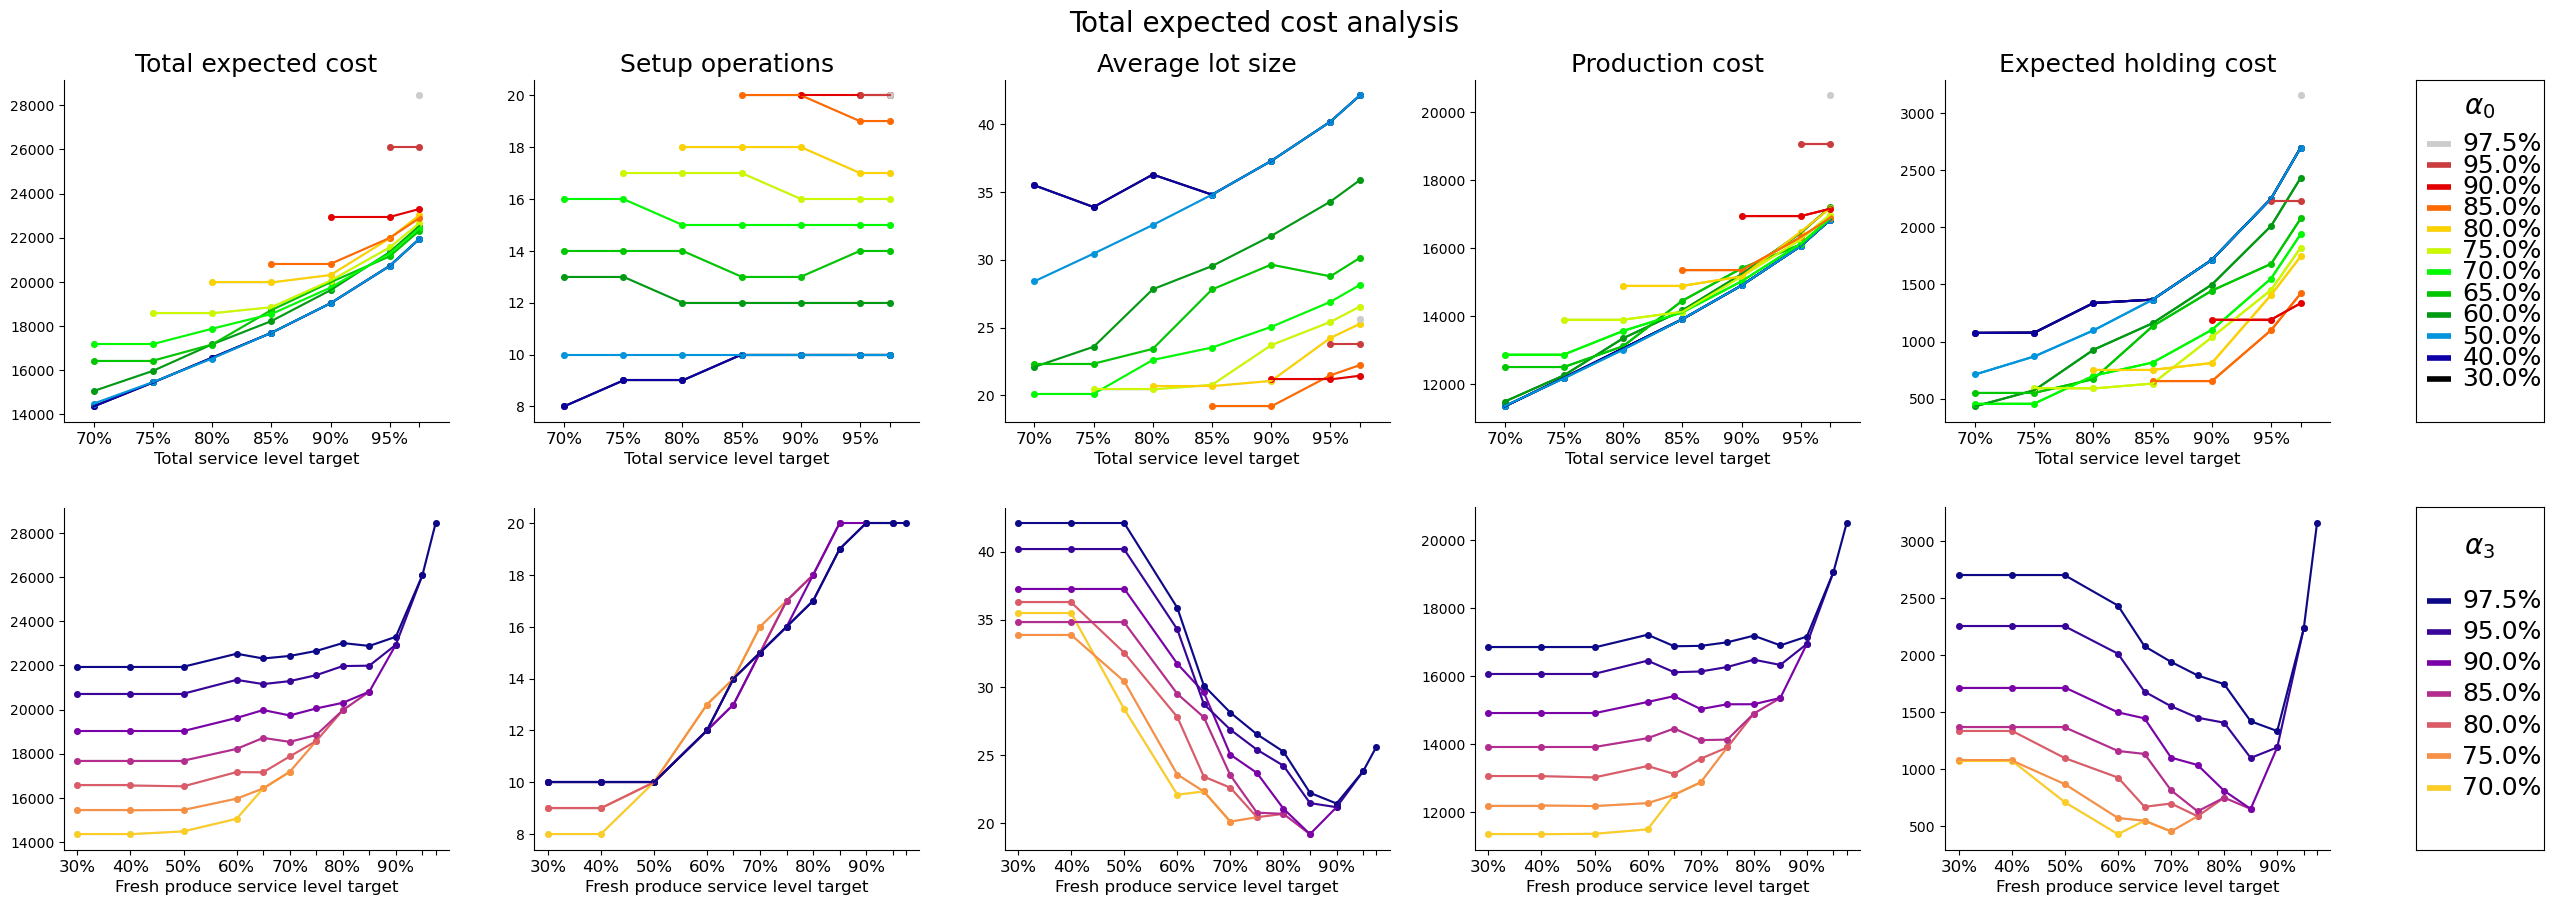

In [43]:
b0 = a0+[]; bn1 = an1+[]
interactive_total_cost_analysis(T, G, S, f, c, h, a0, an1, y, I, x, b0, bn1)

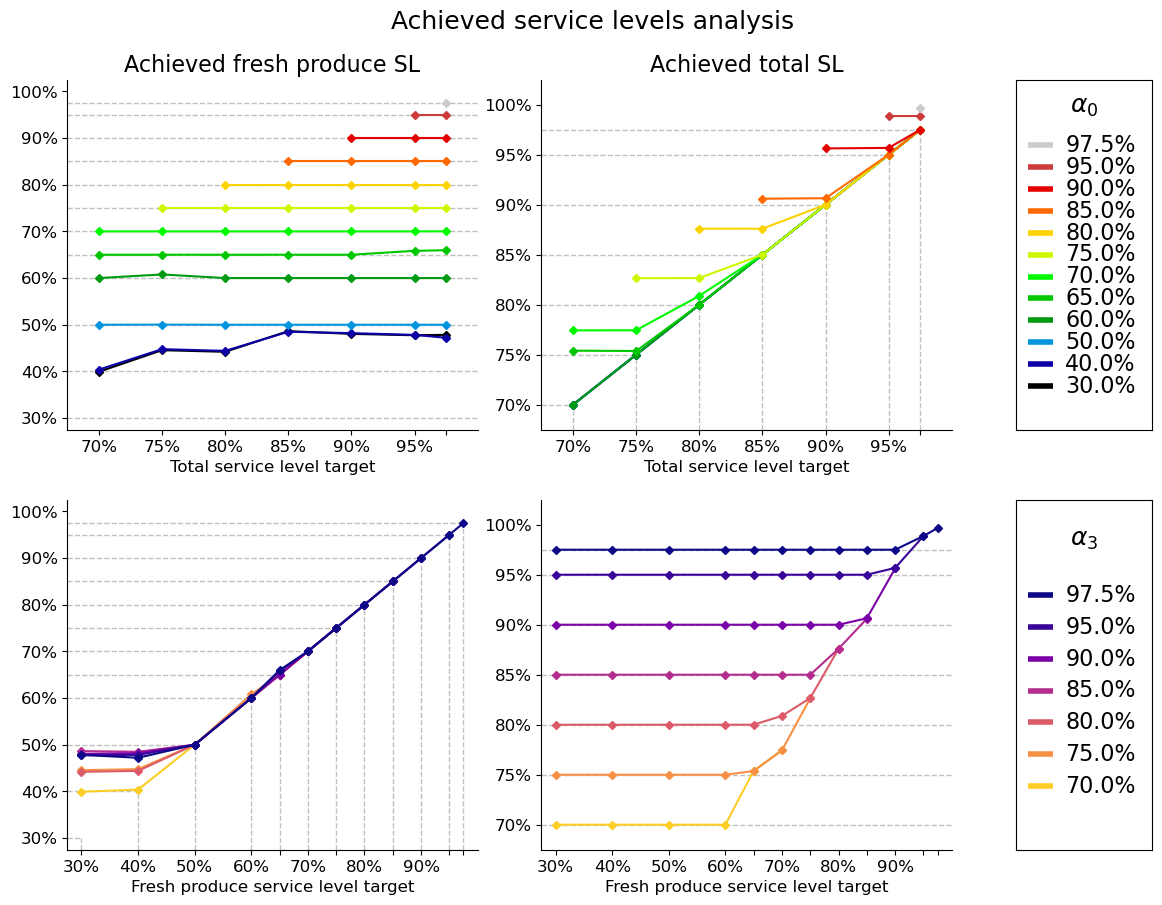

In [44]:
achieved_service_levels_analysis(G, S, a0, an1, total_sl)

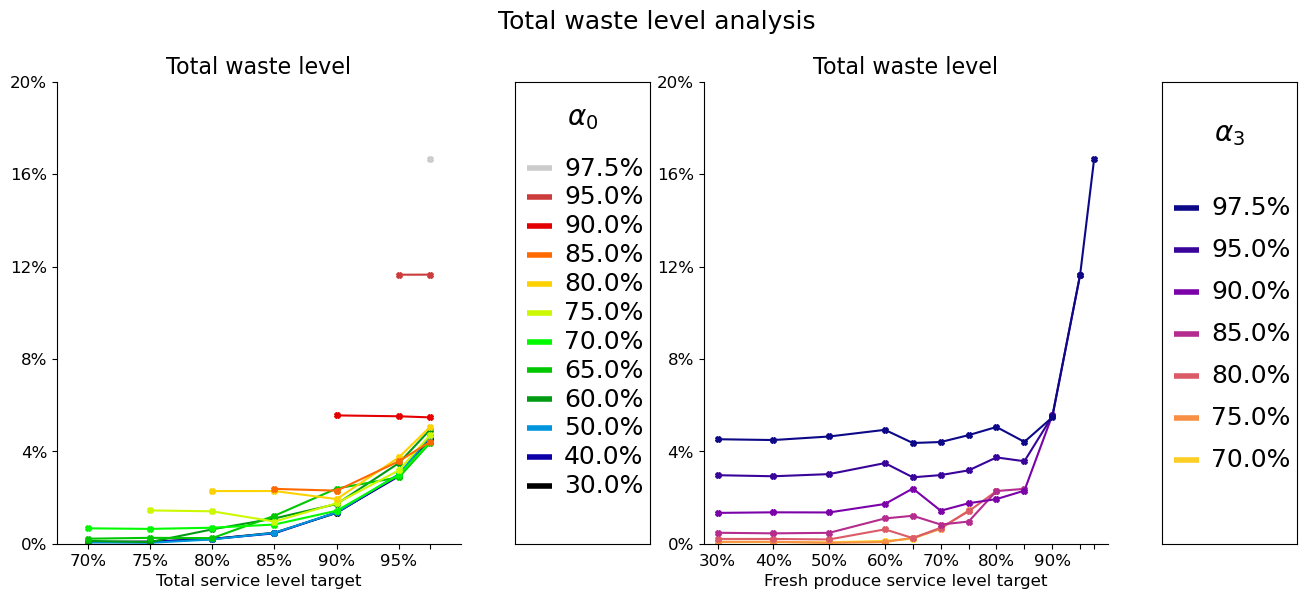

In [45]:
waste = waste_level_analysis(T, G, S, a0, an1, n, x, I)

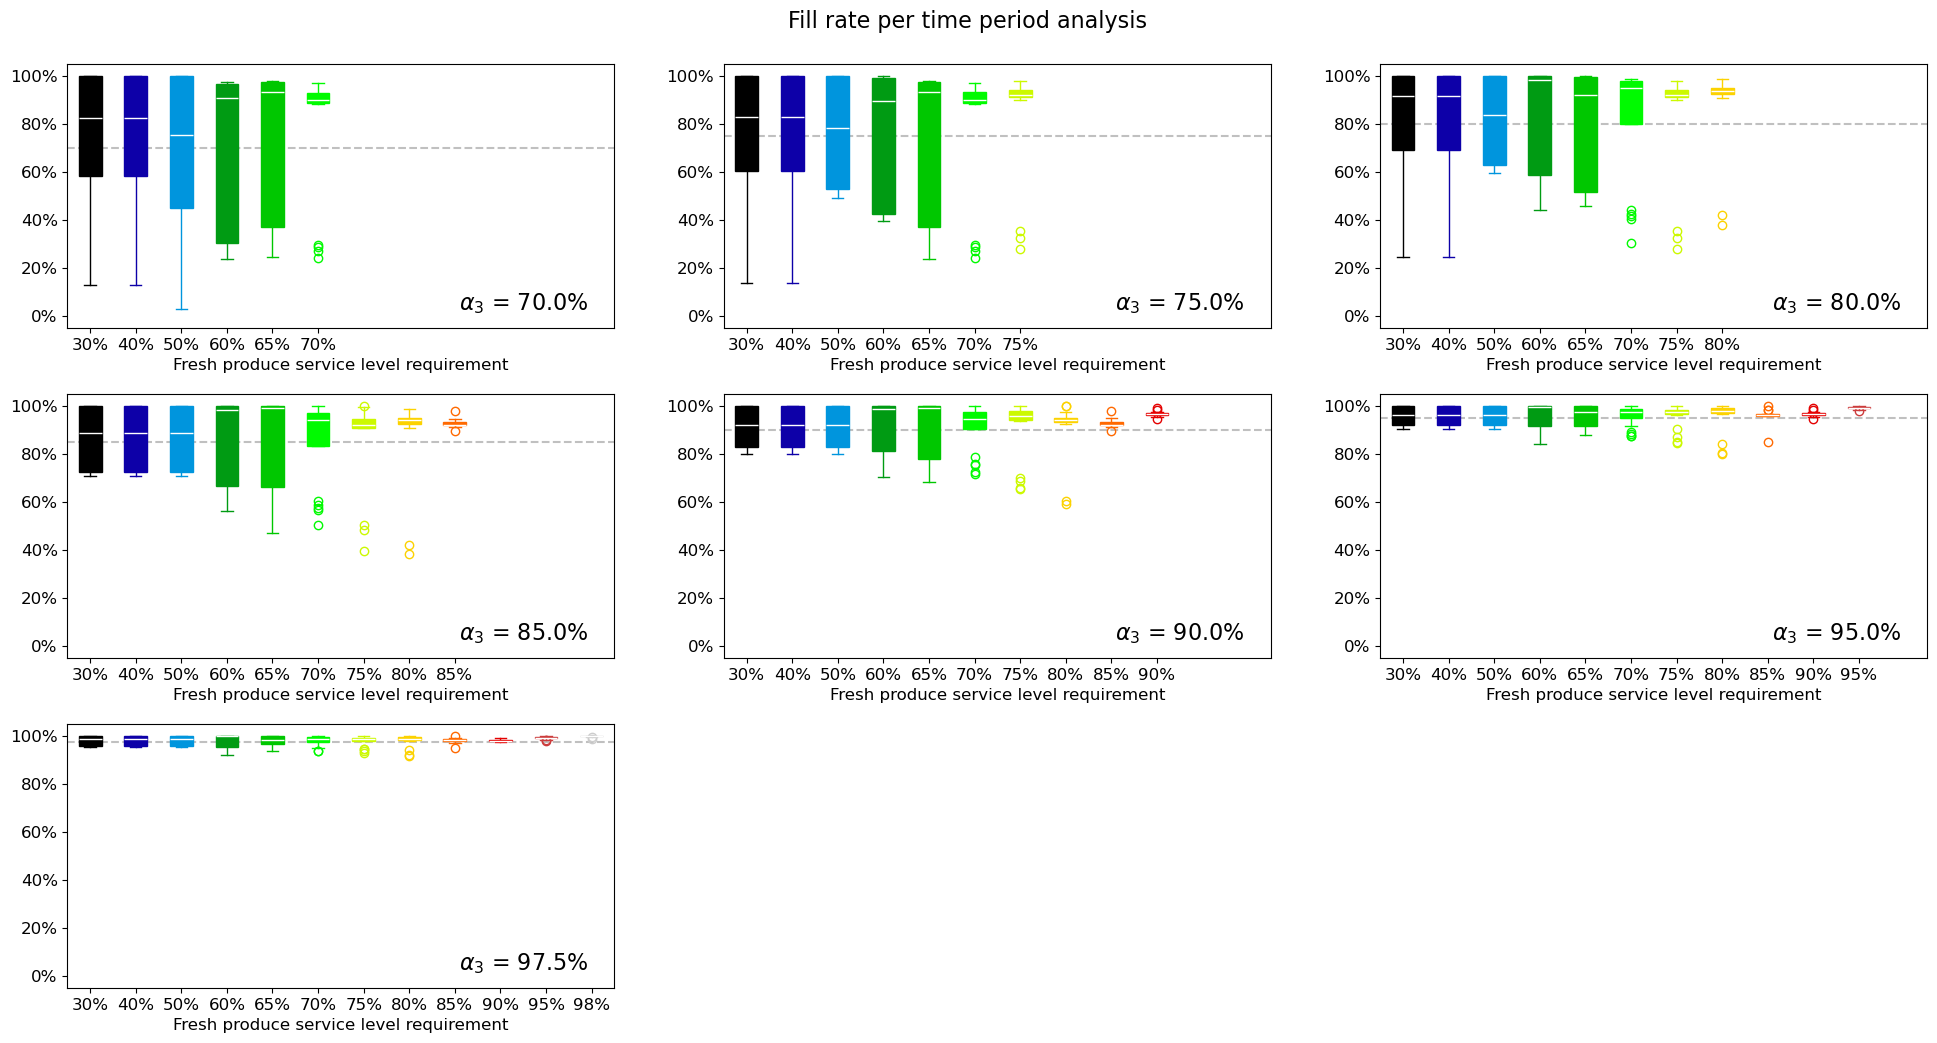

In [46]:
period_sl = period_fill_rate_analysis(T, G, S, a0, an1, d, z, show=True)

In [52]:
file = open(f"C:/Users/ari_r/OneDrive - Universidad de los Andes/Montreal 2024-10/Experiments/Parameters/Complete_{2}", "rb")
(T,S,G,n,d,C) = load(file); file.close()

I0 = {g:0 for g in G[:-1]}; phi = {s:1/len(S) for s in S}

file = open(f"C:/Users/ari_r/OneDrive - Universidad de los Andes/Montreal 2024-10/Experiments/Experiment_complete_{2}_wo", "rb")
(y, x, z, l, w, I, sl, total_sl, waste, period_sl, alpha) = load(file); file.close()

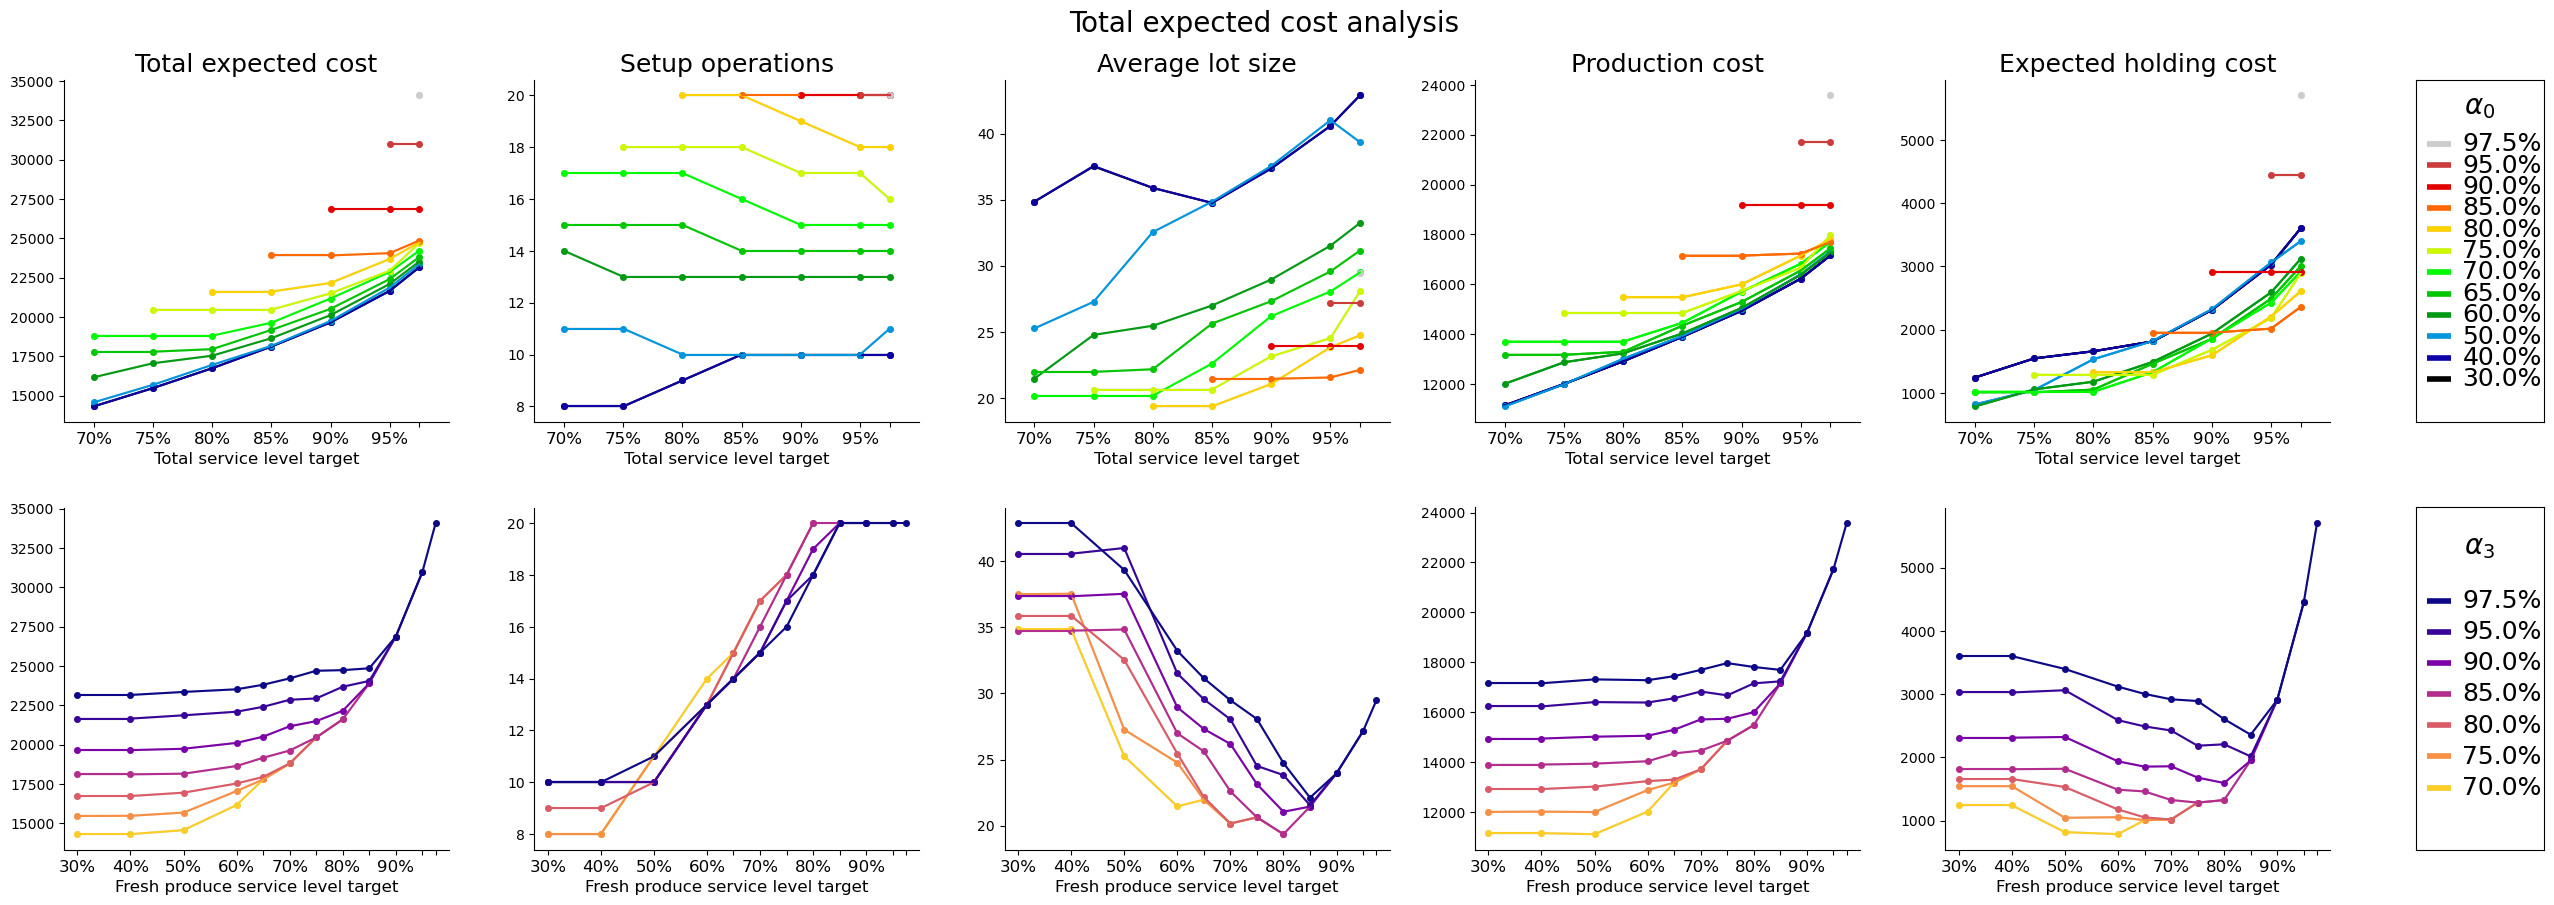

In [53]:
b0 = a0+[]; bn1 = an1+[]
interactive_total_cost_analysis(T, G, S, f, c, h, a0, an1, y, I, x, b0, bn1)

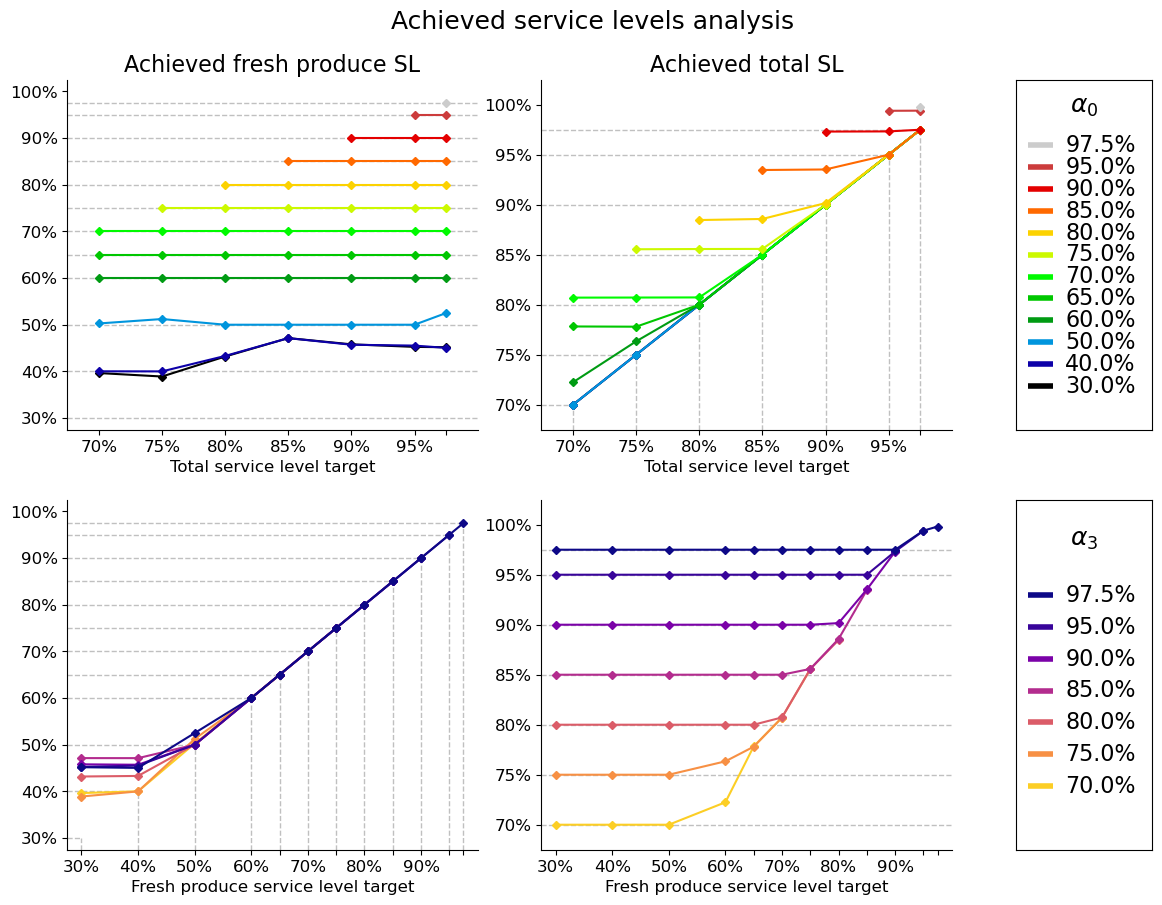

In [54]:
achieved_service_levels_analysis(G, S, a0, an1, total_sl)

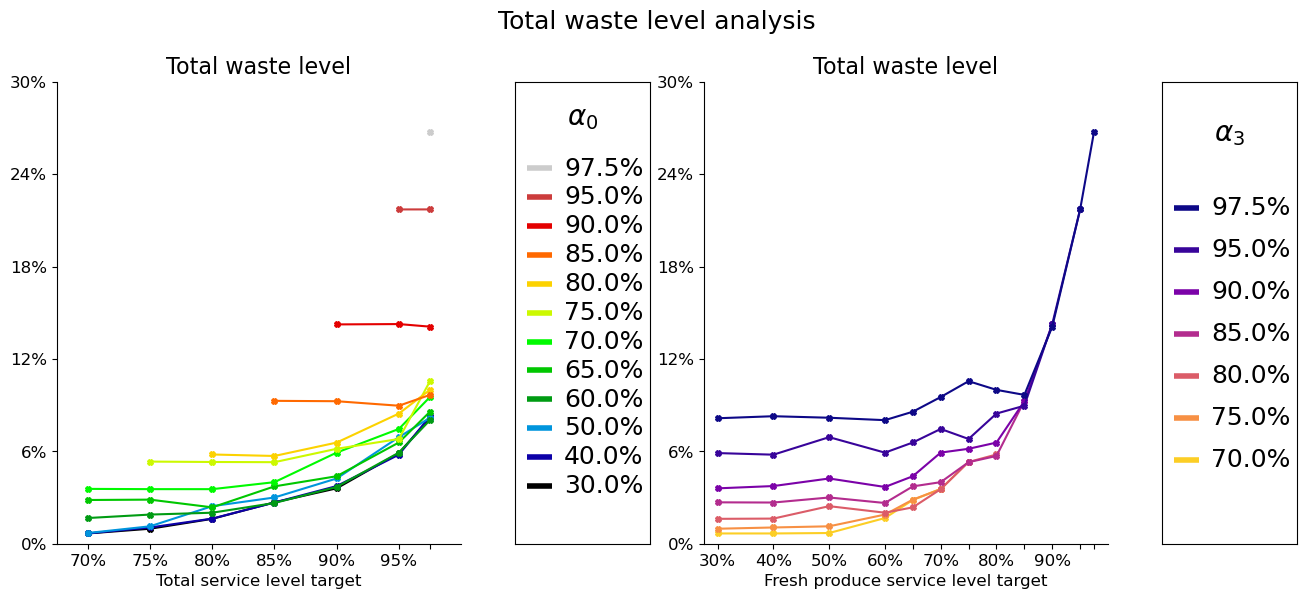

In [55]:
waste = waste_level_analysis(T, G, S, a0, an1, n, x, I)

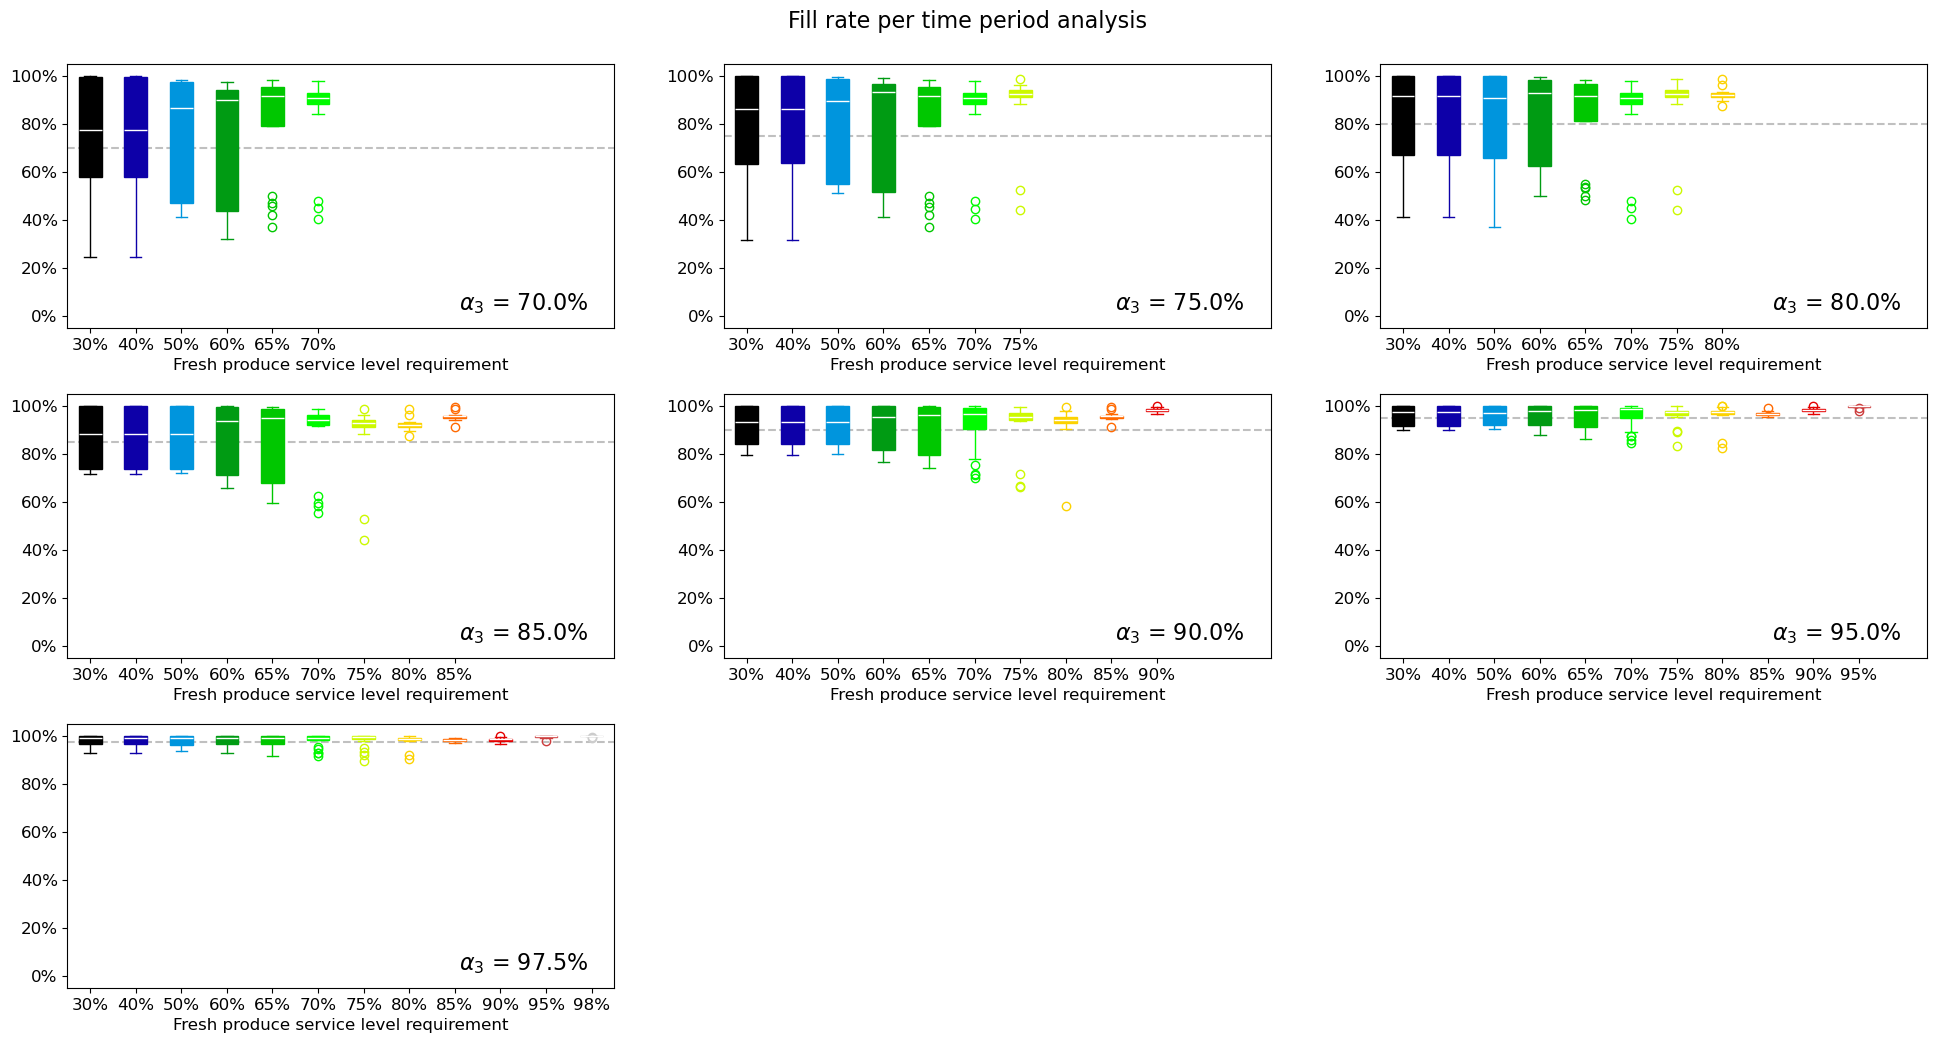

In [56]:
period_sl = period_fill_rate_analysis(T, G, S, a0, an1, d, z, show=True)